# Model of Spiking Neurons
## Getting Started

The code to generate spiking data from simulations of leaky integrate and fire neurons is can be found in `src/quadratic_integrate_and_fire.py`.
It uses the Brian2 simulator and creates a hdf5 file containing spike times (and meta data) for every set of parameters.

For example,
```
>>> python ./src/quadratic_integrate_and_fire.py -o ./dat/simulations/lif/test.hdf5 -d 300 -equil 60 -r 80
```
will run a simulation that lasts 300 seconds.

To find out all parameters,
```
>>> python ./src/quadratic_integrate_and_fire.py -h 
optional arguments:
  -h, --help            show this help message and exit
  -o FILE               output path
  -jA 45.0              AMPA current strength, in mV
  -jG 50.0              GABA current strength, in mV
  -jM 15.0              Minis (noise amplitude), in mV
  -r 80.0               Poisson rate (minis), all neurons, in Hz
  -tD 20.0              Characteristic recovery time, in seconds
  -s 42                 RNG seed
  -k 5                  Number of bridging axons
  -d 1200               Recording duration, in seconds
  -equil 120, --equilibrate 120
                        Equilibration duration, in seconds
  -stim off             if/how to stimulate: 'off', 'poisson'
  -stim_rate 20         additional rate in stimulated mods, in Hz
  -mod 0                modules to stimulate, e.g. `0`, or `02` for multiple
  --bridge_weight 1.0   synaptic weight of bridge neurons [0, 1]
  --inhibition_fraction 0.2
                        fraction of neurons that should be inhibitory
```

Then, we can use the helper functions in `ana/plot_helper.py` to visualize the results.

In [1]:
# The autoreload extension allows you to tweak the code in the imported modules
# and rerun cells to reflect the changes.
%load_ext autoreload
%autoreload 2
# this allows us to output the dictionary structure
%load_ext ipy_dict_hierarchy
# matplotlib settings to look decent in the notebook
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# the helpers are in the `/ana/` folder.
import sys
sys.path.append("./../")
from ana import ana_helper as ah
from ana import plot_helper as ph

# lets load and take a look at the file we have created
h5f = ah.prepare_file("./../dat/simulations/lif/test.hdf5")
h5f

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The ipy_dict_hierarchy extension is already loaded. To reload it, use:
  %reload_ext ipy_dict_hierarchy


<class 'benedict.dicts.benedict'>
├── h5                                                                        
│   ├── filename ......................................................... str  ./../dat/si...
│   ├── dsetname ......................................................... str  /
│   └── file ............................................................ File
├── data                                                                      
│   ├── connectivity_matrix_sparse ................................... Dataset  (3463, 2)
│   ├── neuron_axon_end_to_end_distance .............................. Dataset  (160,)
│   ├── neuron_axon_length ........................................... Dataset  (160,)
│   ├── neuron_axon_segments_x ....................................... Dataset  (160, 232)
│   ├── neuron_axon_segments_y ....................................... Dataset  (160, 232)
│   ├── neuron_bridge_ids ............................................ Dataset  (40,)
│   ├── neuron_excit

The `h5f` above is just a nested dictionary that corresponds to a loaded hdf5 file. We use those a lot throught the analysis and plotting routines. Whenever an analysis is run, it can use details from known places and add the results directly to the `/ana/` dictionary (without writing to disk).

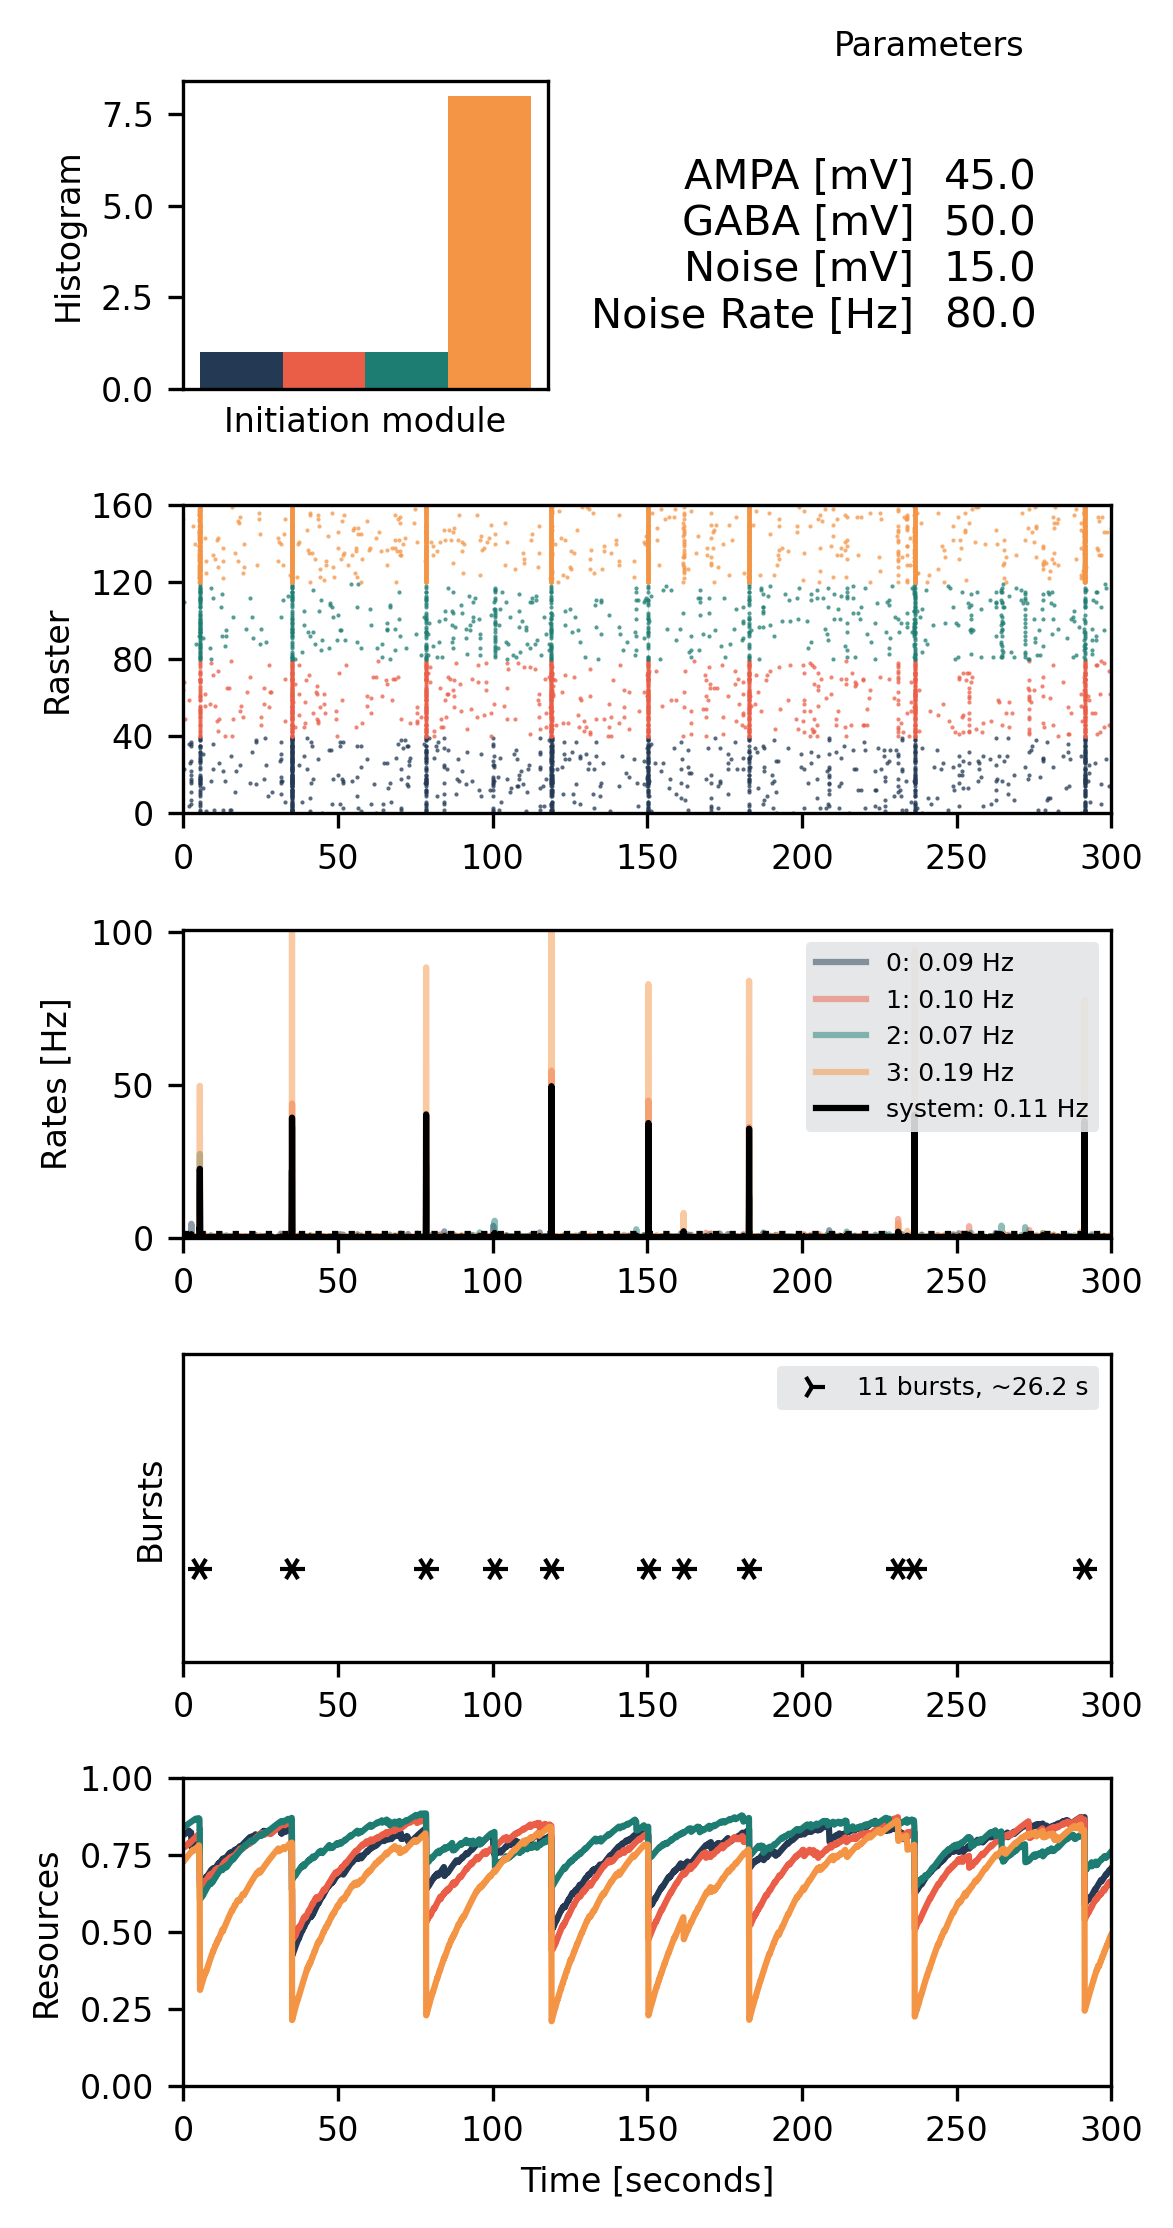

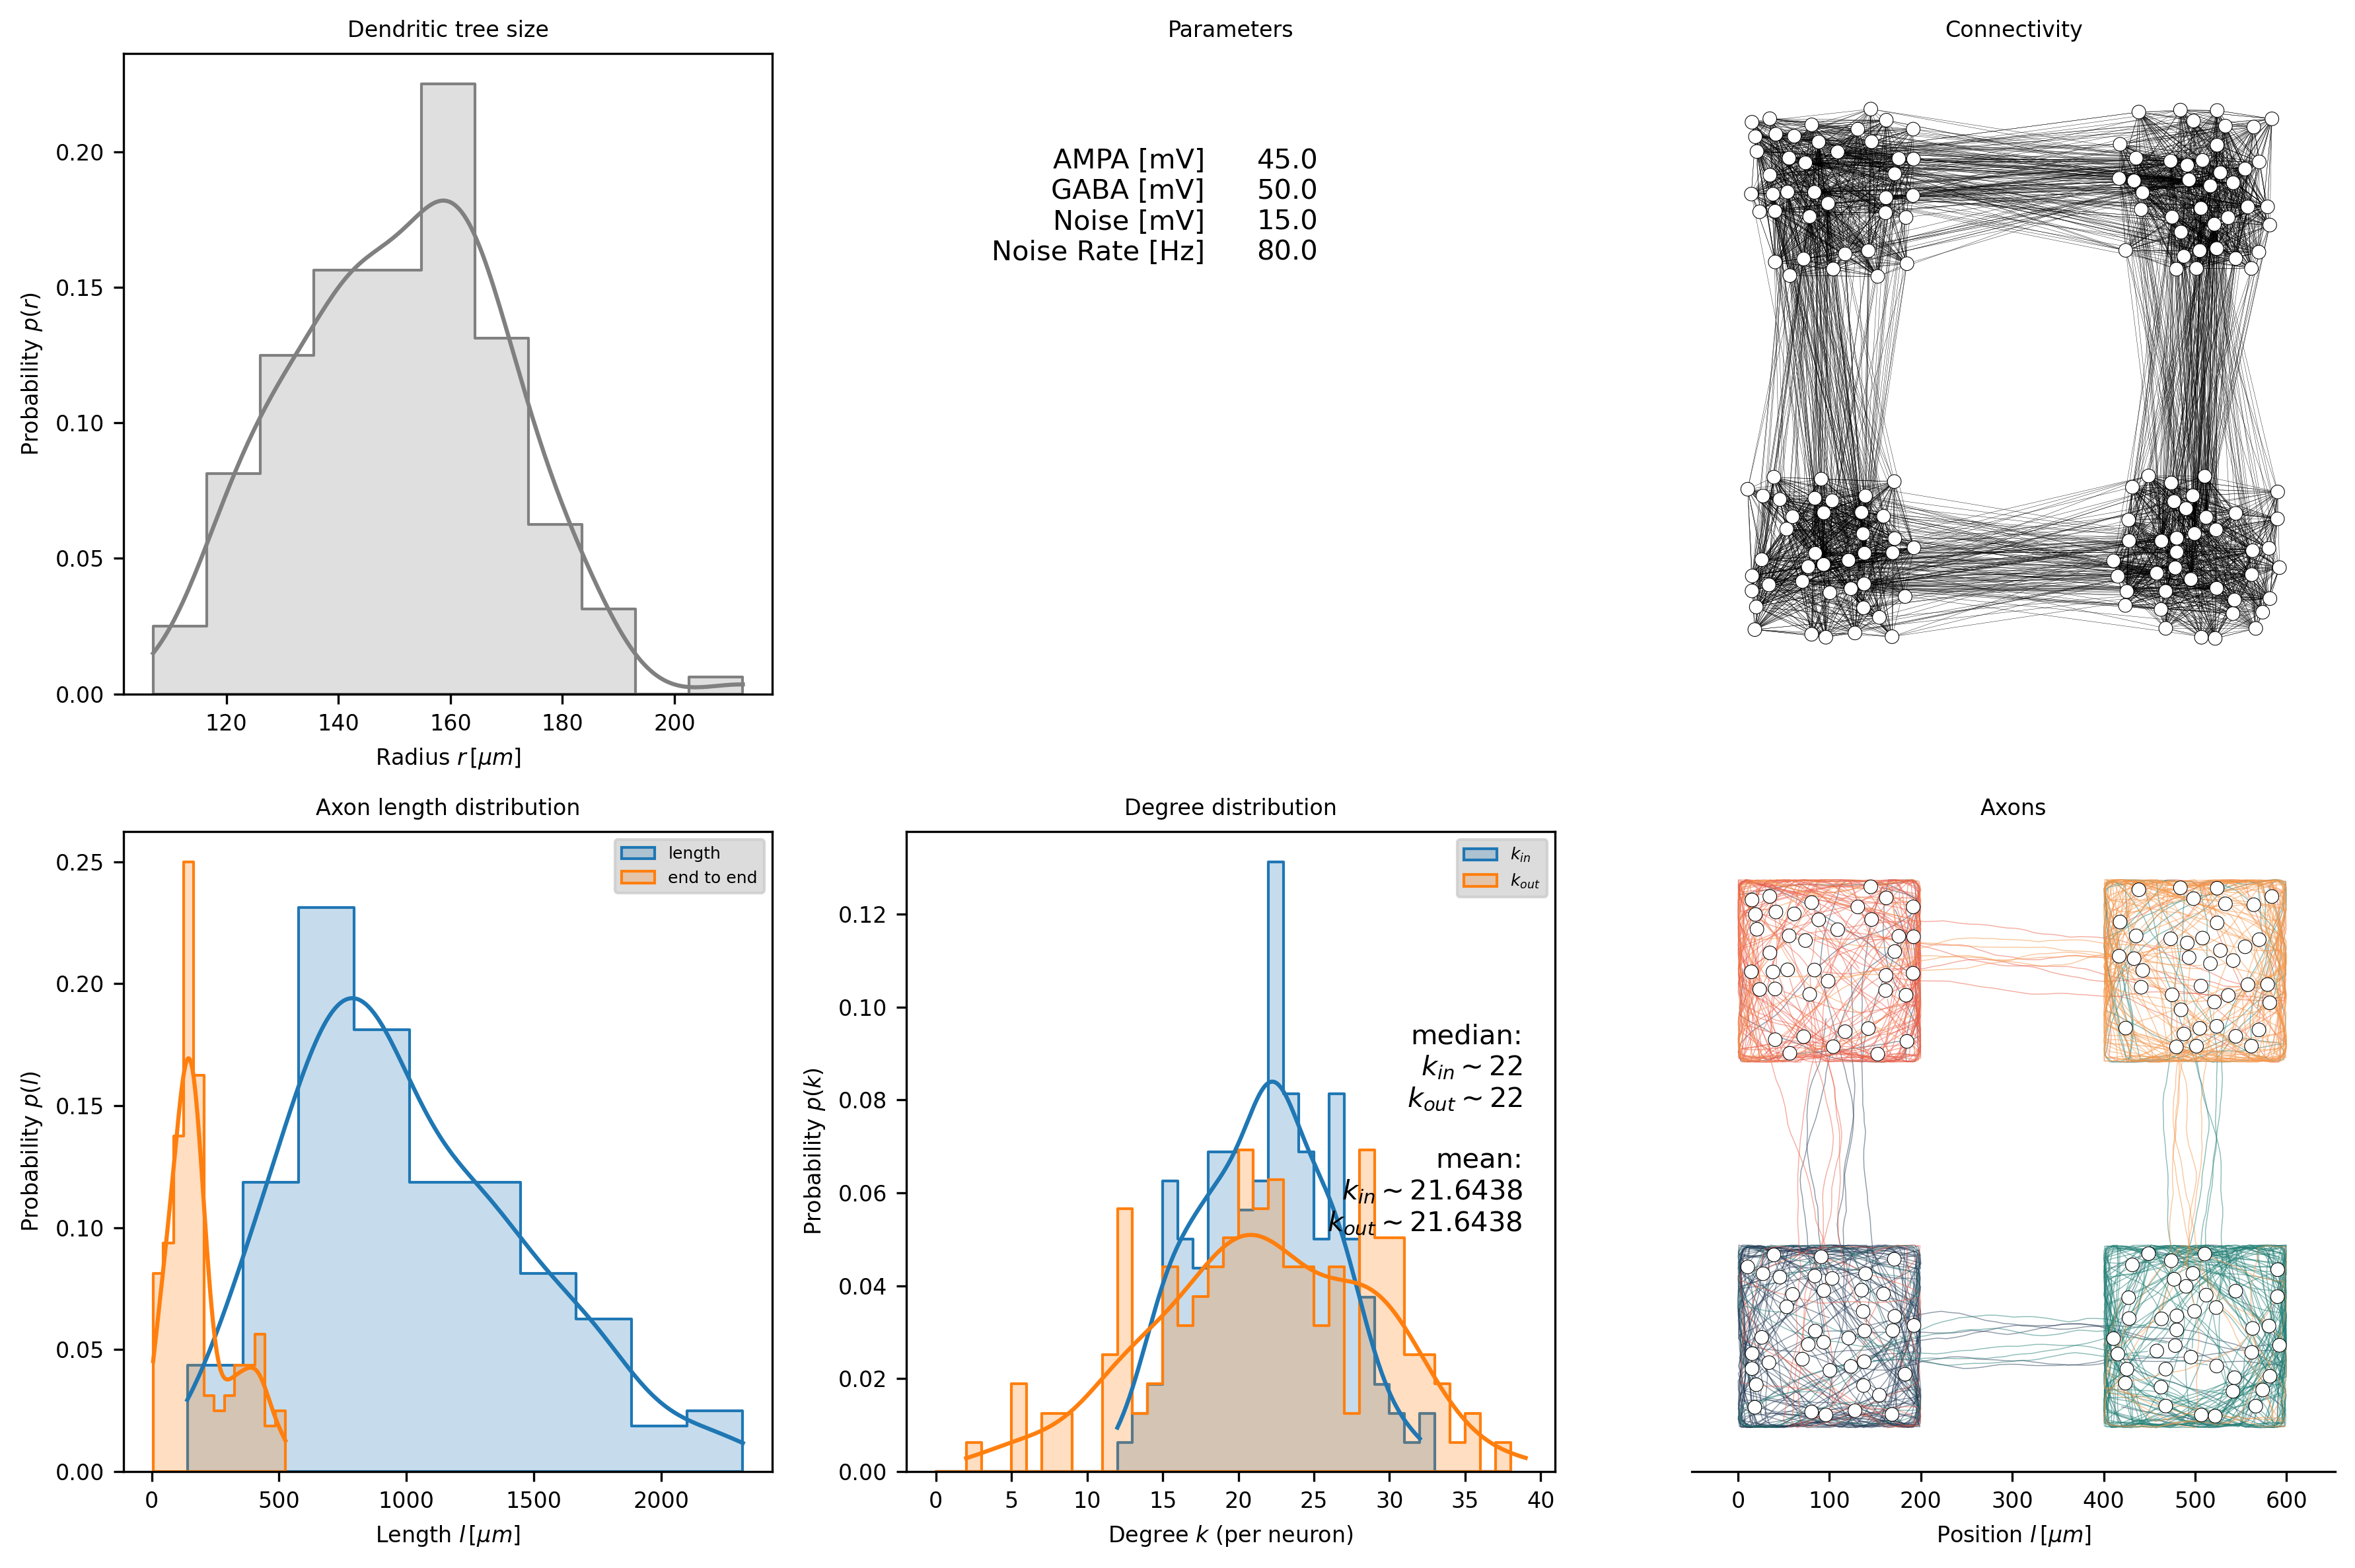

In [2]:
# silence the detailed outputs
ph.log.setLevel("ERROR")
# Note, when using an interactive matplotlib backend, you can zoom and pan the figure,
# which I found useful to explore the the burst behaviour.
ph.overview_dynamic(h5f);
ph.overview_topology(h5f);

## Generating Data
We ran two sets of simulations: stimulating the whole system, or only two modules.
For example, the `run/create_pars_for_global_stimulation.py` produce the parameter combinations we used, each line can be called from terminal.
By default, this produces one hdf5 file (like above) per parameter run in `dat/simulations/lif/raw`.

Note on compute time:
We used 50 realizations per coordinate and topology. Each of those 2k simulations runs approximately in real-time, and we simulate 30 minute recordings.

## Analysing
### Partial stimulation
The simulations with only two modules targeted run through the same script as the experiments
`ana/process_conditions.py` to produce a pre-stim comparison.

The script has the (input and output) filenames hardcoded. It globs the input files that match the right file pattern, depending on `-t sim_partial`, `-t sim_partial_no_inhib` or `-t sim` (global stimulation) and creates and output file matching the `-t` argument.
For instance,
```
python ./ana/process_conditions.py -t sim_partial -i ./dat/simulations/lif/raw/ -o ./dat/simulations/lif/processed/
```
Scans all files in `/dat/simulations/lif/raw/` and outputs `./dat/simulations/lif/processed/k=5_partial.hdf5`.

### Global stimulation
For the global stimulation, we mainly varied the input rate (`-r`) which ended up on the x-axis of most plots.

In order to combine the many runs in the `dat/simulations/lif/raw/` folder, we use the script in `ana/ndim_merge.py`. It takes a wildcarded file path, runs a lot of analysis, and merges the results into a high-dimensional (x-array like) hdf5 file. As this can take a while, it uses dask and can delegate to a cluster.
```
python ./ana/ndim_merge.py -i './dat/simulations/lif/raw/stim=off*jM=15*tD=20*.hdf5' -o ./dat/simulations/lif/processed/ndim.hdf5 -c num_cores
```


## Plots from the paper

In [ ]:
import sys
sys.path.append("../ana/")

import paper_plots as pp
pp.log.setLevel("ERROR")

### Partial Stimulation


    Wrapper for Figure 3 on Simulations containing
    - pooled Violins that aggregate the results of all trials for
        * Event size and Correlation Coefficient
        * at 0Hz vs 20Hz additional stimulation in targeted modules (on top of 80Hz baseline)
    - Decomposition plots (scatter and bar) anaologous to Figure 2
    


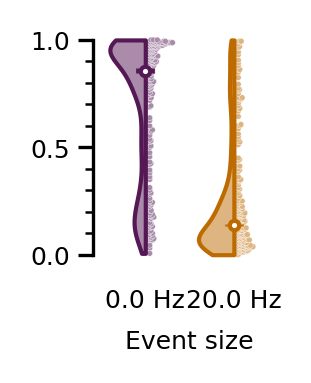

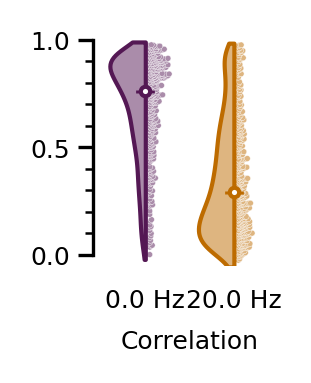

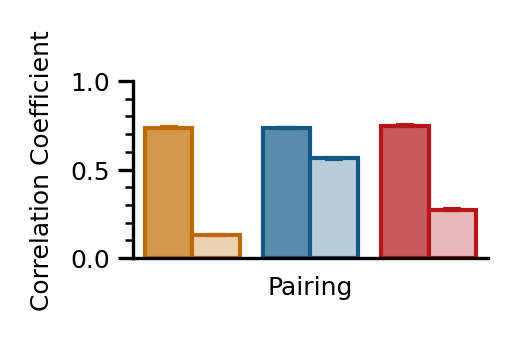

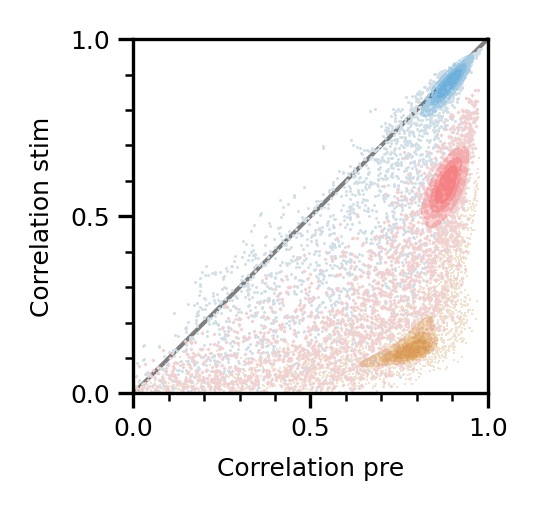

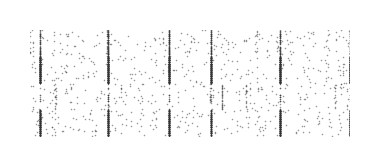

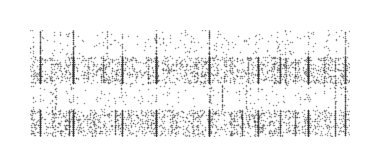

In [12]:
print(pp.fig_3.__doc__)
pp.fig_3()

In [ ]:
# to reproduce the figure 3 for the case with blocked inhibition,
# we need to tweak the file paths a bit:
pp.fig_3(
    # processed data frame
    pd_path=f"{pp.p_sim}/lif/processed/k=5_partial_no_inhib.hdf5",
    # raw data for rasters, note jG=0
    raw_paths=[
        f"{pp.p_sim}/lif/raw/stim=02_k=5_jA=45.0_jG=0.0_jM=15.0_tD=20.0_rate=80.0_stimrate=0.0_rep=001.hdf5",
        f"{pp.p_sim}/lif/raw/stim=02_k=5_jA=45.0_jG=0.0_jM=15.0_tD=20.0_rate=80.0_stimrate=20.0_rep=001.hdf5",
    ],

)

### Stimulation in all modules


    Wrapper for Figure 4 (extended) on Simulations containing
    - As a function of increasing Synaptic Noise Rate:
        * For k=5, the "Fraction of events that span"
            across 4 (dark), 3, 2, or only 1 modules (light)
        * For k=1 (lightest), k=5, k=10 and merged (darkest)
            - Mean Event size (Fraction of neurons that contribute to the event)
            - Mean Correlation Coefficient (neuron pairs)
            - Median and Mean rij (module pairs)
            - Functional Complexity
            - Average Number of spikes each neuron fired during a detected event
            - Inter-event interval
            - Core delay (the delay between the time points of each involved
                modules maximum firing rate)
            - The average amount of synaptic resources at the time of the starting
                of the bursting event
    


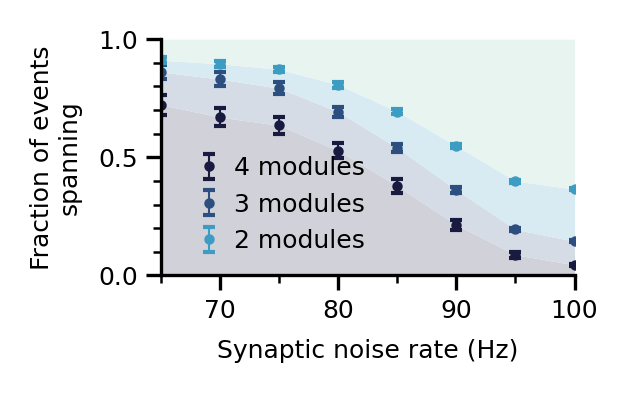

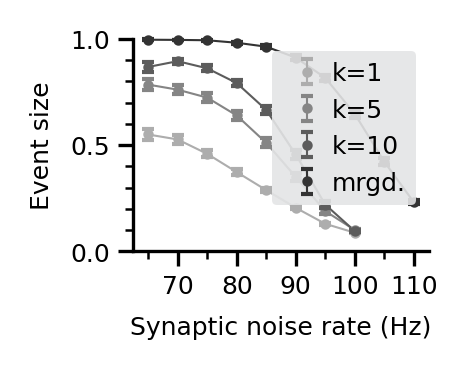

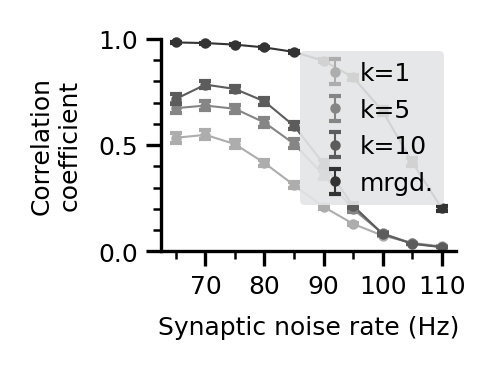

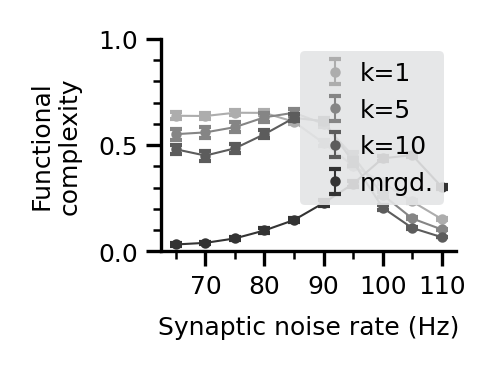

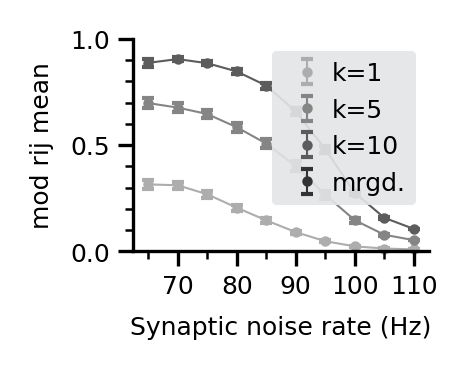

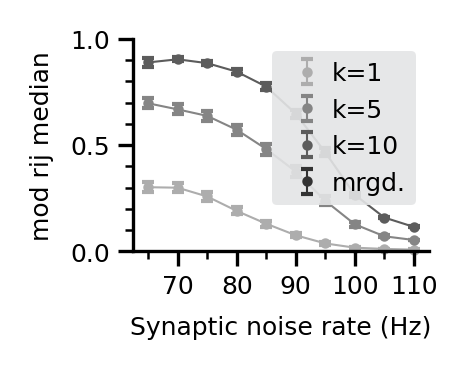

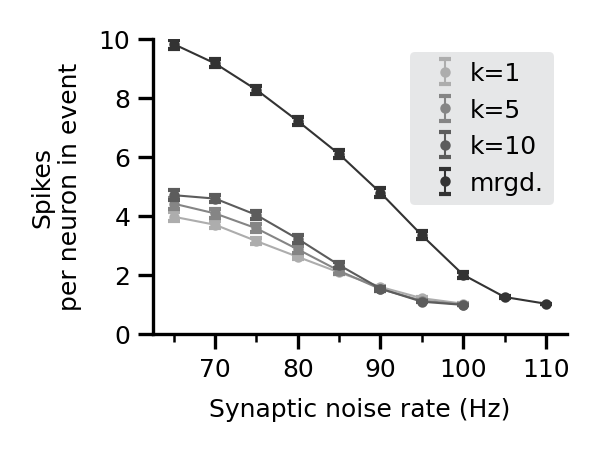

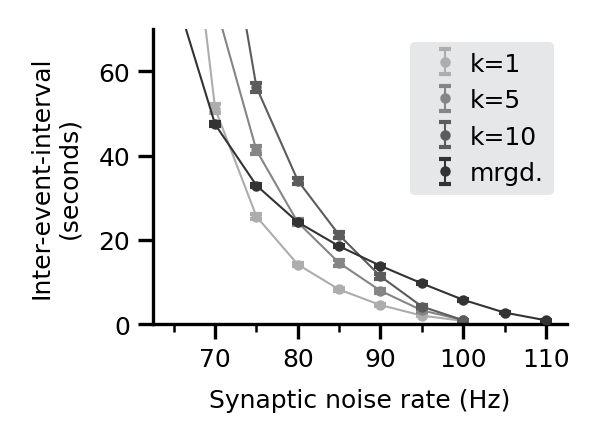

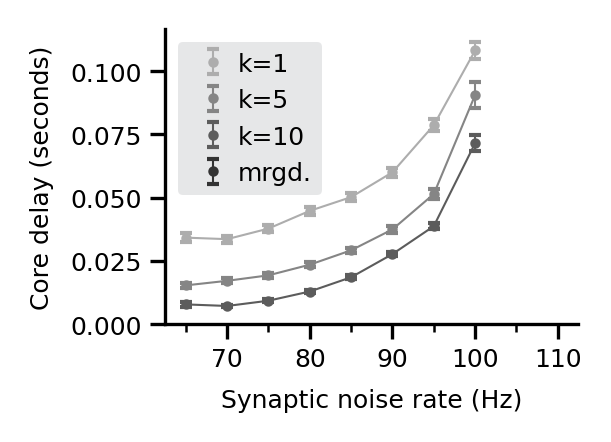

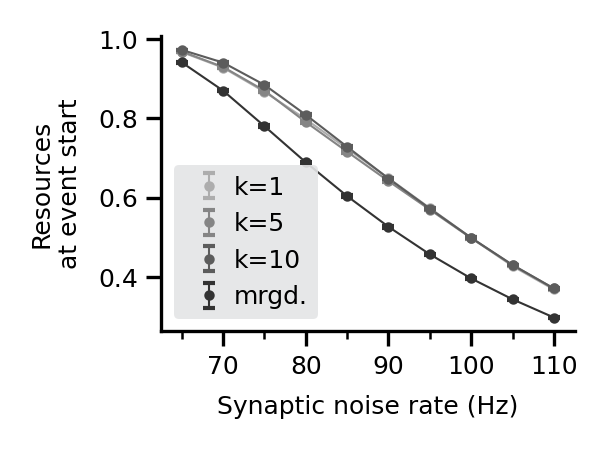

In [13]:
print(pp.fig_4.__doc__)
pp.show_legend = True
pp.fig_4()


    Wrapper to create the snapshots of LIF simulations in Figure 4 and the SM.
    - example raster plots
        * A sketch of the topology
        * Population-level rates in Hz (top)
        * Raster, color coded by module
        * Module-level synaptic resources available (bottom)
        * A zoomin of the raster of a single bursting event (right)
        Sorted by
            - the number of connections between modules (k)
            - and the "Synaptic Noise Rate" - a Poisson input provided to all neurons.
    - charge-discharge cycles for the examples in the raster plots.
    


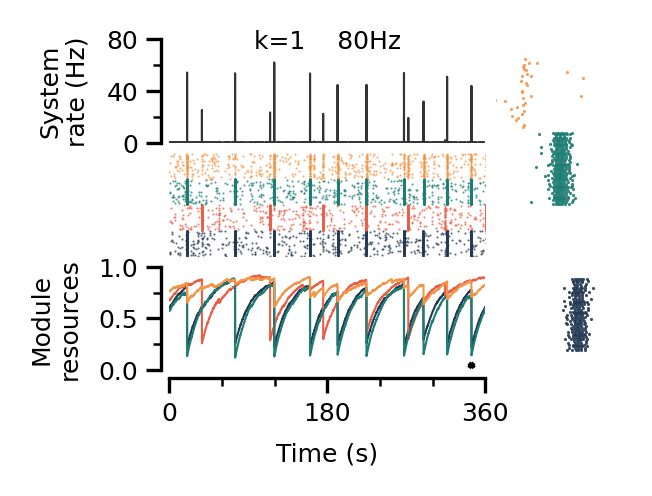

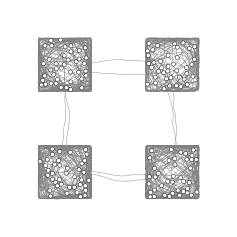

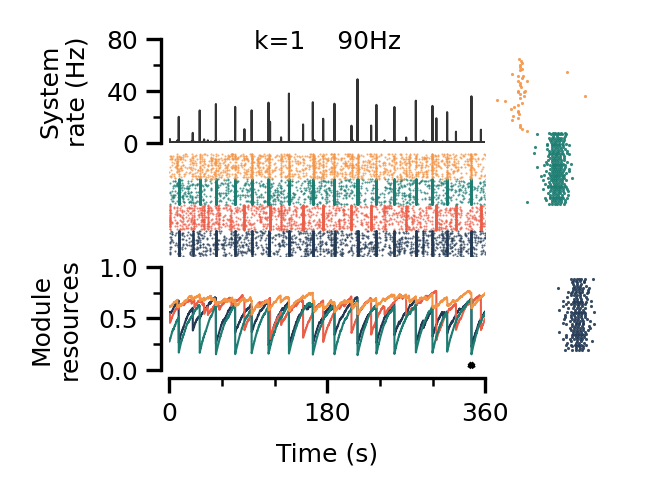

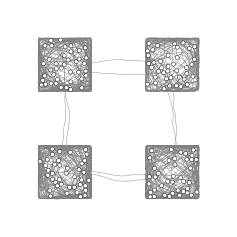

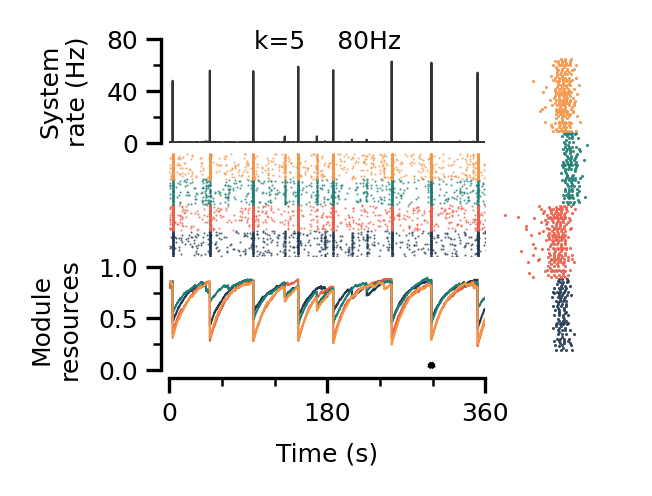

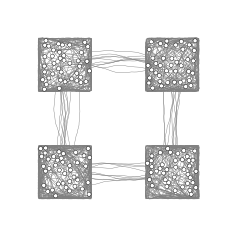

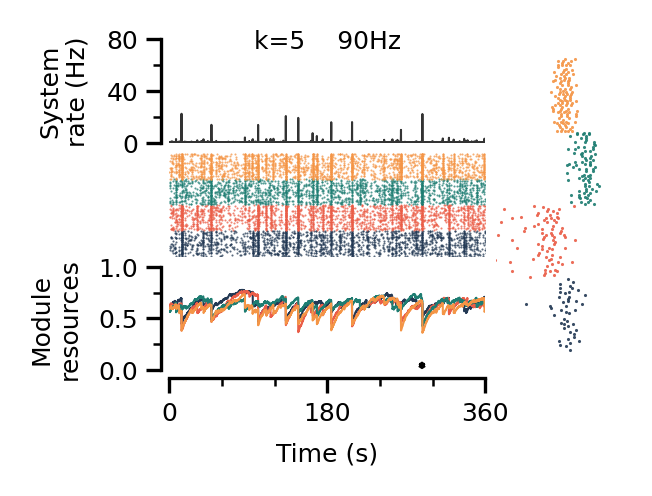

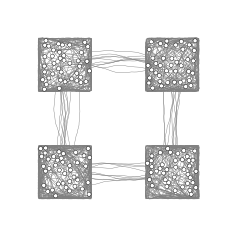

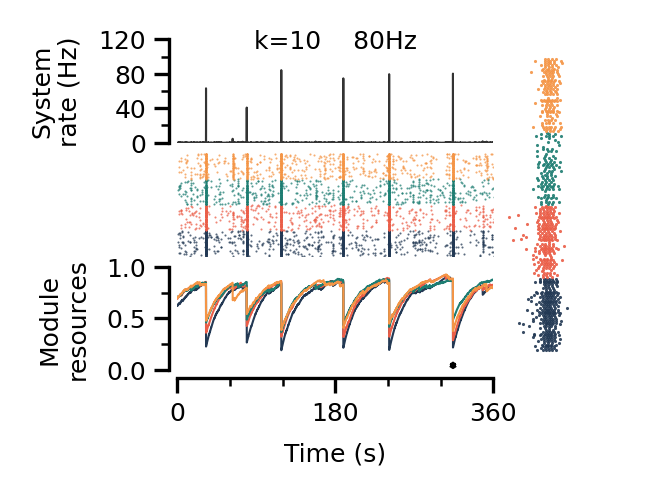

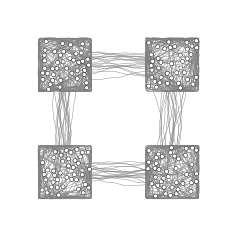

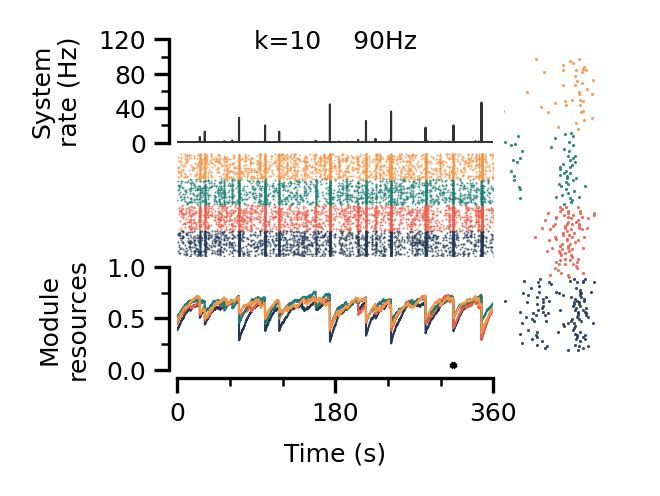

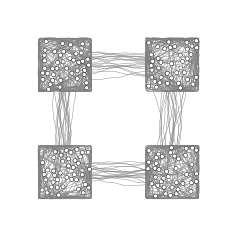

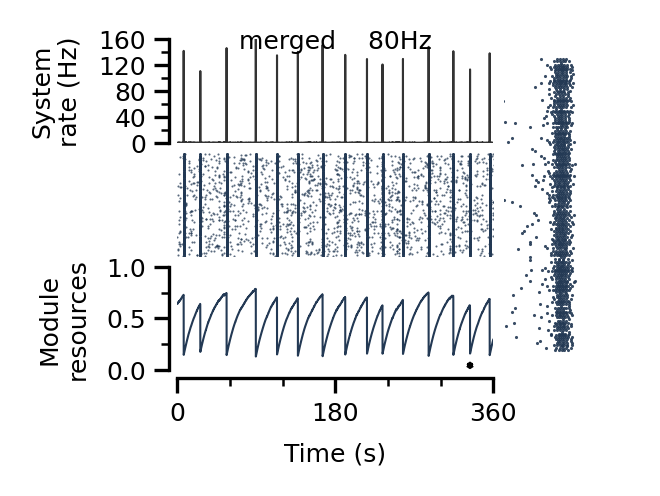

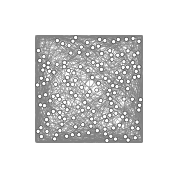

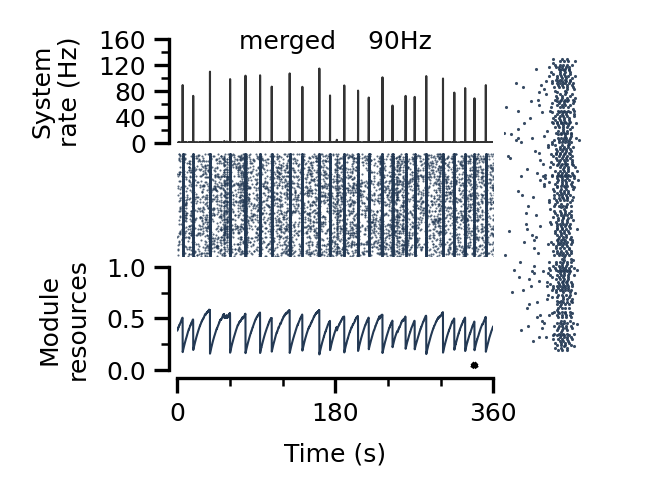

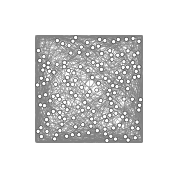

In [14]:
print(pp.fig_4_snapshots.__doc__)
pp.fig_4_snapshots(
    skip_rasters=False,
    # plotting resource cycles takes very long.
    skip_cycles=True,
)

## Inhomogeneous degree distribtions

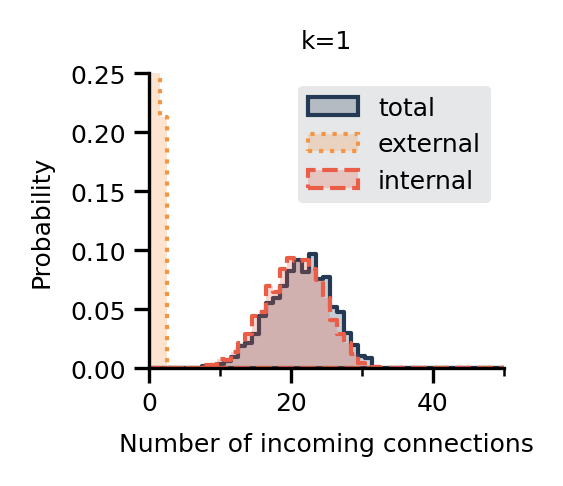

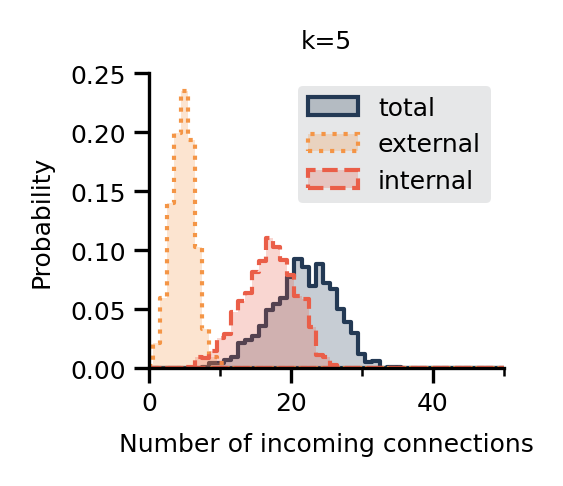

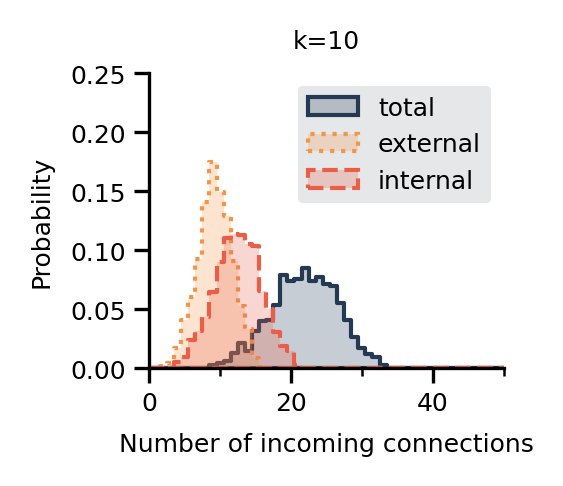

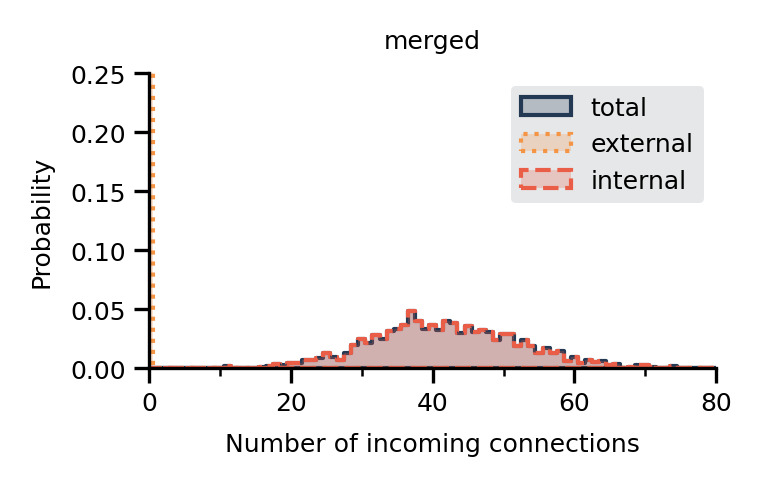

In [15]:
for k in [1, 5, 10, -1]:
    pp.sim_degrees_sampled(k_inter=k, num_reps=10)